# LightGBM

> 하이퍼 파라미터가 XGBoost와 거의 유사

부스팅 계열 알고리즘의 끝판왕.

사실상 윈도우 전용.

XGBoost가 하이퍼 파라미터를 튜닝하면 학습 시간이 매우 오래 걸리는데 이를 획기적으로 단축한 모델.

> Microsoft Visual C++ 재배포 가능 도구가 설치되어야함.

```shell
pip install lightgbm
```

전체 성능(GUI 사용)을 내기 위해서는 `Install Visual Studio (2015 or newer)`이 필요.

## #01. 패키지

> Microsoft Visual C++ 재배포 가능 도구가 설치되어야함.

```shell
pip install lightgbm
```

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from matplotlib import pyplot as plt
import seaborn as sb
from pandas import read_excel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# 성능향상
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

## #02. 데이터 로드 및 전처리

In [3]:
# 데이터 로드
origin = read_excel("data/breast_cancer.xlsx")
# print(origin.info())
# origin.head()

# 독립/종속변수 분리
x = origin.drop('target', axis=1)
y = origin['target']
# x.shape, y.shape

# 데이터 스케일링
std_x = StandardScaler().fit_transform(x)

# 훈련/검증 데이터 분리(test_size 미지정시 자동 0.25)
x_train, x_test, y_train, y_test = train_test_split(std_x, y, random_state=2021)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((426, 30), (143, 30), (426,), (143,))

### 데이터 불균형 처리

#### Over Sampling - SMOTE

소수 집단의 데이터를 바탕으로 새로운 데이터를 생성.

단순히 소수 집단의 데이터를 복원 추출하는 것이 아니라 소수 집단 데이터를 분석해 어떤 특징이 있는지 살피고 그와 유사한 패턴을 가지는 가짜 데이터를 생성.

##### `sampling_strategy 파라미터`

sampling_strategy : 2진 분류일 경우 실수로 설정 가능

| 값 | 설명 |
| -- | -- |
| `minority` | `소수 클래스만` 다시 샘플링 |
| `not majority` | `다수 아님` : 다수 클래스를 제외한 모든 클래스를 다시 샘플링 |
| `not minority` | `소수 아님` : 소수 클래스를 제외한 모든 클래스를 다시 샘플링 |
| `all` | `모든 클래스`를 다시 샘플링 |
| `auto` | 자동 처리 |

혹은 실수 타입으로 설정할 경우 샘플 수의 비율을 의미

##### `k_neighbors 파라미터 (int)`

합성 샘플을 생성하는데 사용할 샘플의 가장 가까운 이웃 수 (기본값=5)

In [4]:
# SMOTE 적용
x_sm, y_sm = SMOTE(random_state=2021).fit_resample(x_train, y_train)
x_sm.shape, y_sm.shape, x_test.shape, y_test.shape

((530, 30), (530,), (143, 30), (143,))

## #03. 단일 학습 모델

### 학습 모델 적합 및 성능 확인

| 파라미터명 | 설명 |
| -- | -- |
| n_estimators(num_boost_rounds) | 부스팅 반복 횟수 |

`eval_metric`

- 검증에 사용되는 함수를 정의.
- defalut는 회귀인 경우는  `rmse`, 분류일 경우에는 `error`이다.

In [6]:
lgbm = LGBMClassifier(
    learning_rate=0.05, 
    max_depth=5, 
    n_estimators=400, 
    n_jobs=-1, 
    random_state=2021
)
lgbm.fit(x_sm, y_sm)

print("훈련 정확도 :", lgbm.score(x_sm, y_sm))

# 예측 값
y_pred = lgbm.predict(x_test)
print("테스트 정확도 :", accuracy_score(y_test, y_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 265, number of negative: 265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5308
[LightGBM] [Info] Number of data points in the train set: 530, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

#### 혼동 행렬

In [7]:
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[49,  2],
       [ 1, 91]], dtype=int64)

#### 각종 성능지표 확인

In [13]:
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, pred_probs)
print("정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f},  F1 : {3:.4f}, AUC : {4:.4f}".format(accuracy, precision, recall, f1, roc_auc))

정확도 : 0.9790, 정밀도 : 0.9785, 재현율 : 0.9891,  F1 : 0.9838, AUC : 0.9970


#### 변수별 중요도 확인

feature_names 미지정으로 이름을 알아보기 어려움

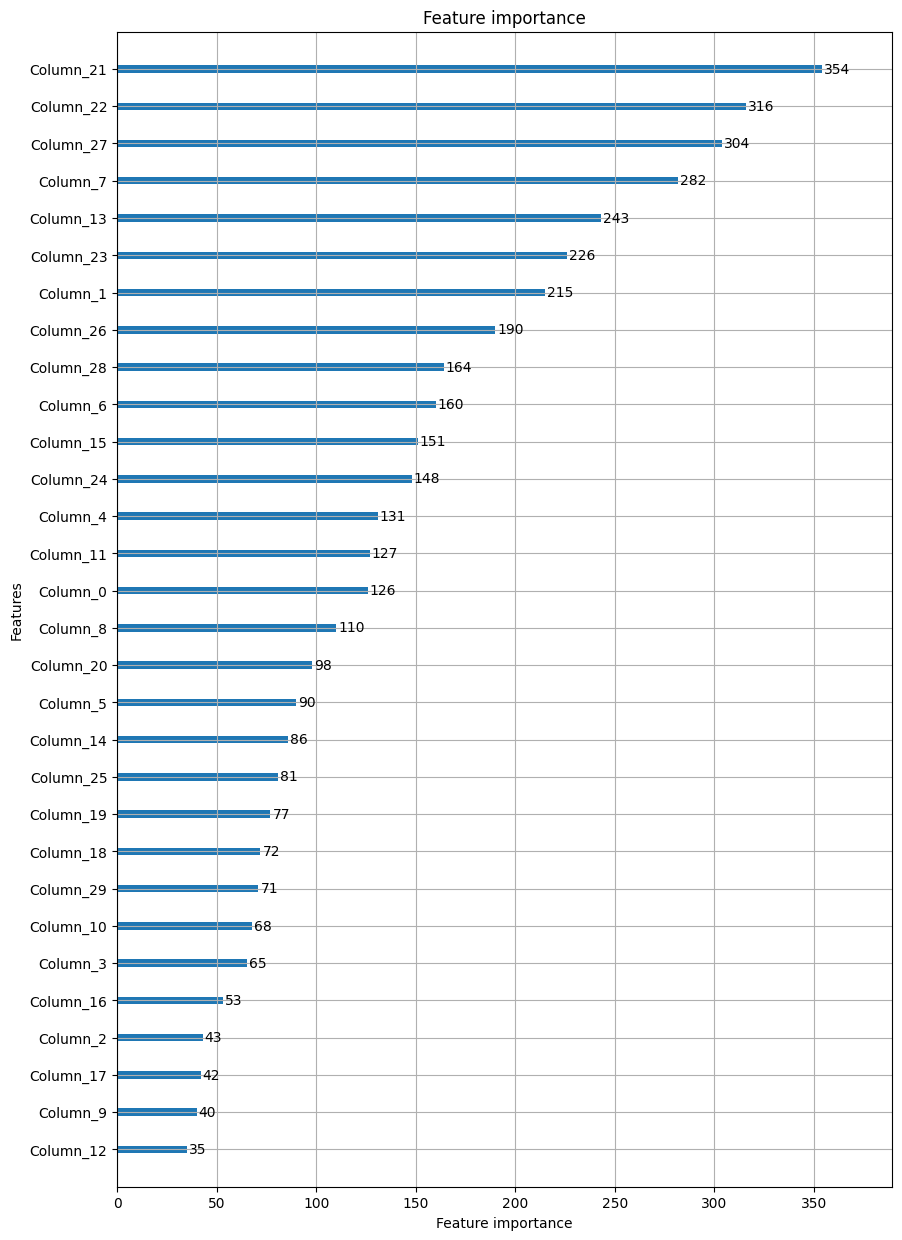

In [14]:
plt.figure(figsize=(10,15))
# xgb.DMatrix에서 feature_names 설정 안 하면 이름이 안 나와서 알아보기 어려움
plot_importance(lgbm, ax=plt.gca())
plt.show()
plt.close()

## #03. 하이퍼 파리미터 튜닝

### 주요 파라미터

| 파라미터 명[기본값] | 설명 |
|--|--|
| num_iterations[default=100]     | 반복수행하려는 트리의 개수 지정(사이킷런에서 XGB의                           |
|                                 | n_estimators 과 같은 파라미터)                                 |
| learning_rate[dafault = 0.1]    | 0~1사이의 값을 지정하며, 부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값       |
|                                 | (n_estimators를 크게하고, learning_rate를 작게해서 예측성능을 주로할 수있음) |
| max_depth[default =-1]          | 트리 기반 알고리즘의 max_depth와 같다.                              |
|                                 | 0보다 작은값으로 지정시, 깊이에 대한 제한이 없음                            |
| min_data_in_leaf[default =20]   | DecisionTree의 min_samples_leaf와 같음                      |
|                                 | * 사이킷런 LGBM에서는 min_child_samples로 쓴다                    |
|                                 | "최종 결정 클래스인 리프노드가 되기 위해서 최소한으로 필요한 레코드의 수"              |
| num_leaves                      | 하나의 트리가 가질 수 있는 최대 리프 개수                                |
| boosting[default =gbdt]         | 부스팅의 트리를 생성하는 알고리즘을 기술                                  |
|                                 | gbdt : 일반적 그래디언트 부스팅 결정트리                               |
|                                 | rf : 랜덤 포레스트                                            |
| bagging_fraction[default = 1.0] | 트리가 커져서 과적합 되는 것을 제어하기 위해, 데이터를 샘플링 하는 비율을 지정           |
|                                 | *사이킷런LightGBMClassifier에서는 subsample로 변경                |
| feature_fraction[default = 1.0] | 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율                         |
|                                 | 과적합을 막기위해 사용                                            |
|                                 | (LightGBMClassifier : colsample_bytree 로 변경)            |
| lambda_l2[default = 0.0]        | L2 regulation 제어용                                       |
|                                 | reg_lambda로 변환                                          |
| lambda_l1[default =0.0]         | L1 regulation 제어용                                       |
|                                 | reg_alpha로 변환                                           |

#### Learning Task Parameter

objective : 최솟값을 가져야 할 손실함수를 정의 (XGBoost의 objective 파라미터와동일) 회귀,다중 클래스 분류, 이진분류에 따라 objective인 손실함수가 지정

In [18]:
lgbm = LGBMClassifier(random_state=777, n_jobs=-1)
params = {
"n_estimators": [300, 400],
"learning_rate": [0.05, 0.1, 0.15],
"max_depth": [5, 7]
}
# 하이퍼파라미터 튜닝 모델
grid = GridSearchCV(lgbm, param_grid=params, scoring='accuracy', cv=5)
# 학습
grid.fit(x_sm, y_sm)

# 검증 정확도 유도
print(grid.best_params_)
print(grid.best_score_)
best_model = grid.best_estimator_
best_model

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 212, number of negative: 212
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4246
[LightGBM] [Info] Number of data points in the train set: 424, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

LGBMClassifier(learning_rate=0.05, max_depth=7, n_estimators=300, n_jobs=-1,
               random_state=777)

#### 성능 지표 확인

In [19]:
y_pred = best_model.predict(x_test)
accuracy = accuracy_score(y_test , y_pred)
precision = precision_score(y_test , y_pred)
recall = recall_score(y_test , y_pred)
f1 = f1_score(y_test, y_pred)
print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}'.format(accuracy, precision, recall, f1))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
정확도 : 0.9720, 정밀도 : 0.9681, 재현율 : 0.9891, F1 : 0.9785
